In [1]:
import geopandas as gpd
import shapely
from shapely.ops import unary_union
from bc_power import utils, hydro
import pandas as pd
from shapely.geometry import Point
import pypsa
import numpy as np
import atlite
import pyomo
import matplotlib.pyplot as plt
import math
from pypsa.networkclustering import get_clustering_from_busmap
import matplotlib.dates as mdates

pyomo.__version__

'6.5.0'

### Merging shapely polygons

In [2]:
gdf = gpd.read_file("/mnt/c/Users/pmcw9/Delta-E/PICS/Data/regions/gadm41_CAN_1.json")
mask = gdf['NAME_1'] == "BritishColumbia"
west_lon = gdf[mask].geometry.bounds['minx'].iloc[0]
south_lat = gdf[mask].geometry.bounds['miny'].iloc[0]
east_lon = gdf[mask].geometry.bounds['maxx'].iloc[0]
north_lat = gdf[mask].geometry.bounds['maxy'].iloc[0]

<Axes: >

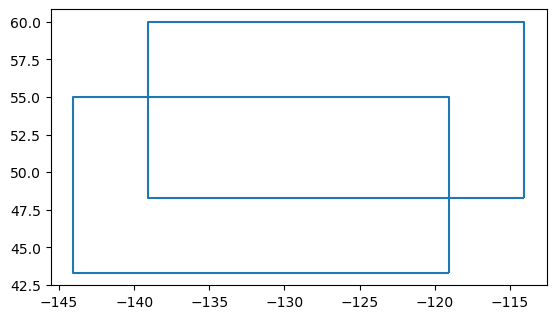

In [3]:
bbox = (west_lon, south_lat, east_lon, north_lat)
polygon_1 = shapely.geometry.box(*bbox, ccw=True)

bbox_2 = (west_lon-5, south_lat-5, east_lon-5, north_lat-5)
polygon_2 = shapely.geometry.box(*bbox_2, ccw=True)

polys = [polygon_1, polygon_2]

gpd.GeoSeries(polys).boundary.plot()

In [ ]:
west_lon,south_lat,east_lon ,north_lat

### Loading configuration file and testing extraction of year

In [ ]:
config_file = r"/mnt/c/Users/pmcw9/Delta-E/PICS/PyPSA_BC/config/config.yaml"
cfg = utils.load_config(config_file)

In [ ]:
start_year = cfg['cutout']["snapshots"]["start"][0][:4]
end_year = cfg['cutout']["snapshots"]["end"][0][:4]

In [ ]:
prefix = cfg['cutout']['path'] + cfg['cutout']['region']["name"]
suffix = "2021" + ".nc"

"_".join([prefix, suffix])

### Loading BC Hydro Load Data and Community Energy and Emissions Inventory

In [ ]:
bch = pd.read_csv("/mnt/c/Users/pmcw9/Delta-E/PICS/Data/BCH/BalancingAuthorityLoad2020.csv")
ceei_path = "/mnt/c/Users/pmcw9/Delta-E/PICS/Data/CEEI/bc_utilities_energy_and_emissions_data_at_the_community_level.xlsx"
ceei_bch = pd.read_excel(ceei_path,sheet_name="BC Hydro")
ceei_fbc_elec = pd.read_excel(ceei_path,sheet_name="FBC Elec") # Will not use data prior to 2013 otherwise need to pull Kelowna records too
ceei_nw = pd.read_excel(ceei_path,sheet_name="NewWest")
ceei_nel = pd.read_excel(ceei_path,sheet_name="NelsonHydro")
ceei_gf = pd.read_excel(ceei_path,sheet_name="GrandForks")
ceei_pen = pd.read_excel(ceei_path,sheet_name="Penticton")
ceei_sl = pd.read_excel(ceei_path,sheet_name="Summerland")
ceei_prc = pd.read_excel(ceei_path,sheet_name="Princeton")
ceei_yk = pd.read_excel(ceei_path,sheet_name="YukonElec")

In [ ]:
elc_col = "CONSUMPTION_TOTAL" # Units of KW-hr
ceei_list = [ceei_bch, ceei_fbc_elec, ceei_nw, ceei_nel, ceei_gf, ceei_pen, ceei_sl, ceei_prc, ceei_yk] # ceei_fbc_elec
year = 2020
tot = 0 # capture total electricity demand in MW-hr for all ELC demands in the dataset
for df in ceei_list:
    mask = (df['YEAR'] == year) & ((df['ORG_TYPE'] != "Province") | (df["SOURCE"] != "BC Hydro"))
    tot += df[mask][elc_col].sum() / 1000 # convert to MW-hr

ratio = bch['Balancing Authority Load'].sum() / tot
print(f"The ratio between the BC Hydro load data and CEEI load is {ratio}")

In [ ]:
bch['Balancing Authority Load']

### Thermal PP

In [2]:
tpp_path = "/mnt/c/Users/pmcw9/Delta-E/PICS/Data/SESIT/CODERS/data-pull/supply/generators.csv"
gen_gen_path = "/mnt/c/Users/pmcw9/Delta-E/PICS/Data/SESIT/CODERS/data-pull/supply/generation_generic.csv"
df = pd.read_csv(tpp_path)
gen_params = pd.read_csv(gen_gen_path)

In [3]:
tpp_gen_types = {'NG_CT', 'NG_CG', 'NG_CC', 'Gas_CT', 'Oil_CT', "Coal", 'Oil_ST', 'Diesel_CT', 'Coal_CCS'}
# BC has only NG_CC, NG_CG, NG_CT
mask = (df["province"] == "BC") & (df["gen_type"].apply(lambda x: x in tpp_gen_types ))
tpp = df[mask].copy()

In [6]:
subset = ["connecting_node_code"]
sum_list = ["install_capacity_in_mw","annual_avg_energy_unit_in_gwh/y"]
tpp.groupby("connecting_node_code",group_keys=False).apply(lambda x: utils.merge_assets(x, subset, sum_list))

,gen_node_code,project_name,owner,province,location,latitude,longitude,copper_balancing_area,operating_region,connecting_voltage_in_kv,...,gen_type_copper,install_capacity_in_mw,capacity_adjustment_in_%,effective_capacity_in_mw,capacity_factor_in_%,annual_avg_energy_unit_in_gwh/y,num_of_units_represented,total_num_of_units,sources,notes
connecting_node_code,,,,,,,,,,,,,,,,,,,,,
BC_FNG_GSS,BC_FNG01_GEN,Fort Nelson_01,BC Hydro,BC,Fort Nelson,58.800980,-122.756204,British Columbia.a,Alberta,138,...,gasCC,80,0.94,49,0.82,432.27,NaN,1.0,"project_name:192, gen_code:None, owner:192, lo...",Interconnected to the AESO
BC_ICG_GSS,BC_ICG00_GEN,Island Generation,V.I. Power Limited Partnership,BC,Campbell River,50.069090,-125.281878,British Columbia.a,British Columbia,138,...,gasCC,290,0.94,273,0.91,2300.00,NaN,1.0,"project_name:194, gen_code:None, owner:194, lo...",NaN
BC_MCM_GSS,BC_MCM01_GEN,McMahon_01,McMahon Cogeneration Plant JV,BC,Taylor,56.146330,-120.671073,British Columbia.a,British Columbia,138,...,gasCC,110,0.94,52,0.87,840.00,NaN,2.0,"project_name:194, gen_code:None, owner:194, lo...",NaN
BC_RPG_GSS,BC_RPG01_GEN,Prince Rupert_01,BC Hydro,BC,Prince Rupert,54.314334,-130.294424,British Columbia.a,British Columbia,69,...,gasSC,46,0.94,22,0.27,107.21,NaN,2.0,"project_name:192, gen_code:None, owner:192, lo...",NaN


In [5]:
tpp['gen_type']

323    NG_CC
324    NG_CC
351    NG_CC
396    NG_CG
397    NG_CG
435    NG_CT
436    NG_CT
Name: gen_type, dtype: object

In [ ]:
gen_params[gen_params['generation_type'] == "NG_CT"].iloc[0]['efficiency']

In [ ]:
gen_params.columns

In [ ]:
tpp['gen_type']

### Testing conceptual cascade in PyPSA
    i) 3 reservoir cascade
    ii) testing spill and discharge

In [27]:
def get_multi_link_override():
    '''
    Gets the multi-link override. Needed for cascaded hydroelectric.
    '''
    # From PyPSA CHP Example: This ensures we can add 2 outputs for a single link i.e bus0 -> bus_1 AND bus_2
    override_component_attrs = pypsa.descriptors.Dict(
        {k: v.copy() for k, v in pypsa.components.component_attrs.items()}
    )
    override_component_attrs["Link"].loc["bus2"] = [
        "string",
        np.nan,
        np.nan,
        "2nd bus",
        "Input (optional)",
    ]
    override_component_attrs["Link"].loc["efficiency2"] = [
        "static or series",
        "per unit",
        1.0,
        "2nd bus efficiency",
        "Input (optional)",
    ]
    override_component_attrs["Link"].loc["p2"] = [
        "series",
        "MW",
        0.0,
        "2nd bus output",
        "Output",
    ]
    return override_component_attrs

def get_cascade_network(load_data, **kwargs):
    '''
    This function is going to replace function above. This function will feature a better design for adding links
    and other components when finished.
    '''
    # setup the network
    network = pypsa.Network(override_component_attrs=get_multi_link_override())
    network.set_snapshots(range(len(load_data)))
    
    network.add("Bus", "elc", carrier="AC")  # This likely will move
    network.add("Carrier", "water") # this may move since RoR also has water 
    network.add("Carrier", "inflow", co2_emissions=0.0) # likely will move
    network.add("Load", "elc demand", bus="elc", p_set=load_data) # likely will move
    
    for res,components in kwargs.items():
        for name,params in components.items():
            network.add(**params)

    return network

def create_reservoir_dict(df, inflow_data, cascade_name="demo"):
    '''
    Accepts a dataframe of reservoirs and their parameters and
    ordering of the the reservoirs. This can be used to create dictionaries
    which will be used to instantiate the model of the reservoir.
    
    Modifications: Likely need to have inflow in csv files which
                   can be imported later.
    '''
    res_dict = {}
    for idx,row in df.iterrows():
        aid = row['asset_id']
        max_inflow = max(inflow_data[aid])
        res_dict[aid] = {}
        

        # 1) add water_bus
        res_dict[aid]['water bus'] = {"class_name":"Bus",
                                          "name":" ".join([aid,"water bus"]),
                                          "carrier":"water",
                                        }

        # 2) add reservoir_bus
        res_dict[aid]['reservoir bus'] = {"class_name":"Bus",
                                          "name":" ".join([aid,"reservoir bus"]),
                                          "carrier":"water",
                                        }

        # 3) add store_link
        res_dict[aid]['store link'] = {"class_name":"Link",
                                       "name": " ".join([aid,"store link"]),
                                       "bus0": res_dict[aid]['water bus']['name'],
                                       "bus1": res_dict[aid]['reservoir bus']['name'],
                                       "efficiency":1., # mass balance
                                       "p_nom":1000000, # FIX: Should be derived to ensure larger than max(inflow + spill + discharge of any upstream reservoirs)
                                        } 
        
        # 4) get release_link
        res_dict[aid]['release link'] = {"class_name":"Link",
                                       "name": " ".join([aid,"release link"]),
                                       "bus0": res_dict[aid]['reservoir bus']['name'],
                                       "bus1": res_dict[aid]['water bus']['name'],
                                       "efficiency":1., # mass_balance
                                       "p_nom":row["s_capacity"] + row['p_capacity'],
                                        } 
        

        # 5) get reservoir store
        res_dict[aid]['reservoir store'] = {"class_name":"Store",
                                            "name":" ".join([aid,"reservoir store"]),
                                            "bus":res_dict[aid]['reservoir bus']['name'],
                                            "e_nom":row["r_capacity"]
                                            }
        
        # 6) add inflow generator
        res_dict[aid]['inflow generator'] = {"class_name":"Generator",
                                            "name": " ".join([aid,"inflow generator"]),
                                            "bus": res_dict[aid]['reservoir bus']['name'],
                                            "carrier": "inflow",
                                            "efficiency":1., # mass_balance
                                            "p_nom":max_inflow, # max(inflow series)
                                            "p_set":inflow_data[aid],
                                            "p_max_pu":[i / max_inflow if i != 0 else 0 for i in inflow_data[aid]],
                                            "p_min_pu":[i / max_inflow if i != 0 else 0 for i in inflow_data[aid]],
                                            } 

        # Terminal check
        if type(row["downstream"]) == str: # not terminal
            downstream_aid = " ".join([row["downstream"],"water bus"])
        else: # terminal
            downstream_aid = " ".join([cascade_name,"water exit"])
            # Add bus for the terminal reservoir
            res_dict[aid]['terminal bus'] = {"class_name":"Bus",
                                                "name":downstream_aid,
                                                "carrier":"water",
                                                }
            
            # Add spill store
            res_dict[aid]['terminal store'] = {"class_name":"Store",
                                                "name":cascade_name,
                                                "bus":downstream_aid,
                                                "e_nom":10000000 # The max storage needs to retain all possible water in the model horizon
                                                }

        # 7) get discharge link
        res_dict[aid]['discharge link'] = {"class_name":"Link",
                                            "name": " ".join([aid,"discharge link"]),
                                            "bus0": res_dict[aid]['water bus']['name'],
                                            "bus1": row['elc_bus'],
                                            "bus2": downstream_aid,
                                            "marginal_cost":0.0001,
                                            "efficiency":row['p_capacity'] / row['q_rated'], # power conversion 
                                            "efficiency2":1., # mass balance
                                            "p_nom":row['q_rated'], # Should be derived to ensure larger than max(inflow, spill + discharge)
                                            } 
        # 8) get spill link
        res_dict[aid]['spill_link'] = {"class_name":"Link",
                                        "name": " ".join([aid,"spill link"]),
                                        "bus0": res_dict[aid]['water bus']['name'],
                                        "bus1": downstream_aid,
                                        "efficiency":1., # mass_balance
                                        "p_nom":row['s_capacity'], # Should be derived to ensure larger than max(inflow, spill + discharge)
                                        }

    return res_dict

In [28]:
res_data = [["r1",1,1,10,0,"r2",np.nan,"elc"],
        ["r2",1,1,10,0,"r3","r1","elc"],
        ["r3",1,1,10,0,np.nan,"r2","elc"]]

inflow_data = {"r1":[10,10,10],"r2":[0,0,0],"r3":[0,0,0]} # {"aid":[inflow_series], ...}

load_data = [1,1,1]

# connecting_node_code will need to be added later
# upstream doesn't matter other than to find the head reservoir
# downstream doesn't matter other than to find the terminal reservoir
reservoirs = pd.DataFrame(res_data, columns=["asset_id","q_rated","p_capacity","s_capacity","r_capacity","downstream","upstream","elc_bus"]) 
res_dict = create_reservoir_dict(reservoirs, inflow_data)
network = get_cascade_network(load_data,**res_dict)
reservoirs.head()

,asset_id,q_rated,p_capacity,s_capacity,r_capacity,downstream,upstream,elc_bus
0,r1,1,1,10,0,r2,NaN,elc
1,r2,1,1,10,0,r3,r1,elc
2,r3,1,1,10,0,NaN,r2,elc


INFO:linopy.model: Solve linear problem using Glpk solver
INFO:linopy.io: Writing time: 0.12s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 69 primals, 159 duals
Objective: 3.00e-04
Solver model: not available
Solver message: optimal



GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp /tmp/linopy-problem-6vewlp1u.lp --output /tmp/linopy-solve-sion9duw.sol
Reading problem data from '/tmp/linopy-problem-6vewlp1u.lp'...
159 rows, 69 columns, 257 non-zeros
991 lines were read
GLPK Simplex Optimizer 5.0
159 rows, 69 columns, 257 non-zeros
Preprocessing...
27 rows, 41 columns, 91 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 27
*     0: obj =   3.000000000e-04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.1 Mb (130264 bytes)
Writing basic solution to '/tmp/linopy-solve-sion9duw.sol'...


/tmp/ipykernel_2790/2312903107.py:26: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax_soc.get_shared_x_axes().join(ax_soc, ax_discharge,ax_inflow)


[Text(0, 0, ''), Text(1, 0, ''), Text(2, 0, '')]

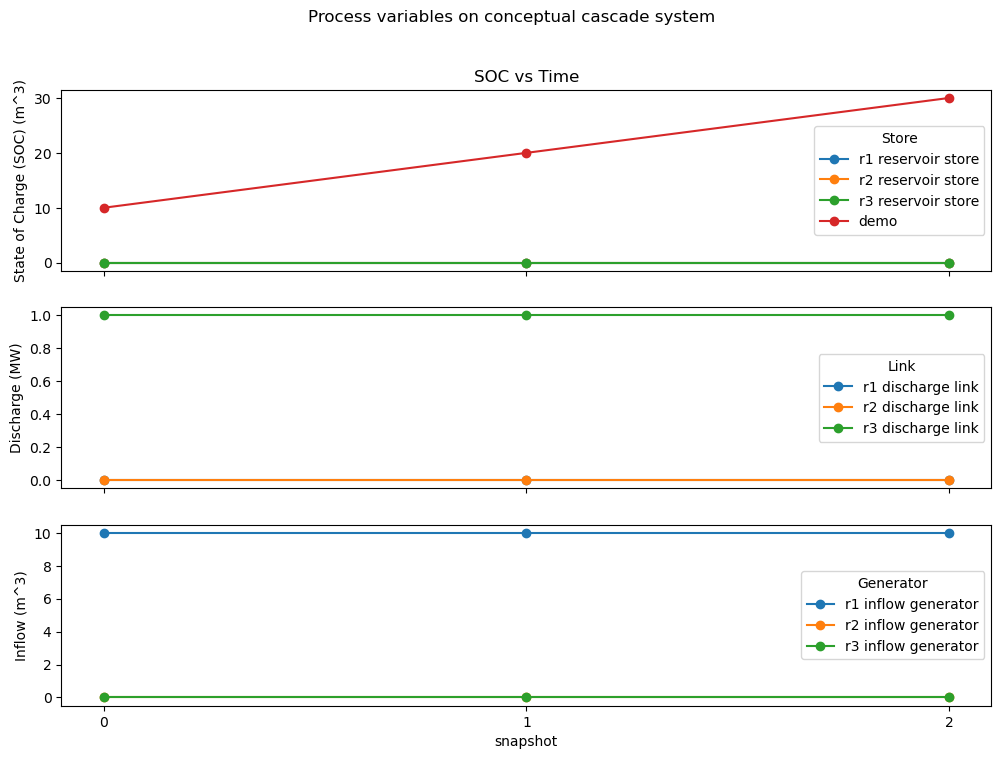

In [31]:
# network.lopf(pyomo=False, solver_logfile="tester.log");
network.optimize(solver_name='glpk')

# create subplots
fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(12,8))
fig.suptitle('Process variables on conceptual cascade system') 
# SOC
ax_soc = network.stores_t.e.plot(ax=axes[0],marker='o')
ax_soc.set_ylabel('State of Charge (SOC) (m^3)')
ax_soc.set_title('SOC vs Time')

# water discharges
col_sel = ["r1 discharge link", "r2 discharge link", "r3 discharge link"]
ax_discharge = network.links_t.p0[col_sel].plot(ax=axes[1],marker='o')
ax_discharge.set_ylabel('Discharge (MW)')

# inflow 
ax_inflow = network.generators_t.p.plot(ax=axes[2],marker='o')
ax_inflow.set_ylabel('Inflow (m^3)')

# Formatting
ax_inflow.set_xticks([0,1,2])
ax_soc.set_xticks([0,1,2])
ax_discharge.set_xticks([0,1,2])

ax_soc.get_shared_x_axes().join(ax_soc, ax_discharge,ax_inflow)
ax_soc.set_xlabel("")
ax_discharge.set_xlabel("")
ax_soc.set_xticklabels([])
ax_discharge.set_xticklabels([])
# ax_soc.sharex(ax_soc, ax_discharge,ax_inflow)

### Testing Thermal PP in PyPSA
    i) Dispatch (check)
    ii) Emissions (check) (global)
    iii) Ramping (check)
    iv) UC (check)
    v) Gas-Grid vs no-Grid (check)
    vi) ramp_limit_start_up ()


In [32]:
def create_tpp_dict(df):
    '''
    Creates a thermal power plant dictionary that is used to add network components of the thermal powerplants.
    '''
    tpp_dict = {}
    for idx,row in df.iterrows():
        aid = row['name']
        tpp_dict[aid] = {}
        # tpp_dict[aid] = row.to_dict()
        # tpp_dict[aid]["class_name"] = "Generator"

        # create link + store representation of generator
        bus_name = " ".join([row['carrier'], "Bus"])
        tpp_dict[aid]= {"class_name":"Link",
                                    "name": " ".join([aid,"gen link"]),
                                    "bus0": bus_name,
                                    "bus1": row['bus'],
                                    "carrier": row['carrier'],
                                    "efficiency":row['efficiency'],
                                    "ramp_limit_up":row["ramp_limit_up"],
                                    "ramp_limit_down":row["ramp_limit_down"],
                                    "p_nom_extendable":False,
                                    "committable":row["committable"],
                                    "min_up_time":row["min_up_time"],
                                    "ramp_limit_start_up":row["ramp_limit_start_up"],
                                    "ramp_limit_shut_down":row["ramp_limit_shut_down"],
                                    "p_nom":row['p_nom'] / row['efficiency'],
                                    "marginal_cost":row['marginal_cost'], # cost per input unit (Need to be careful when combining fuel cost and variable cost 
                                    "p_min_pu":row['p_min_pu'] # watch out for the forced run condition
                                    }
        
    return tpp_dict

def create_tpp_network(load_data,emission_lim, **kwargs):
    '''
    Creates a thermal powerplant network.
    '''
    # setup the network
    network = pypsa.Network() #(override_component_attrs=get_uc_link_override())
    network.set_snapshots(range(len(load_data)))
    
    # Add carriers
    network.add("Carrier", "co2_emissions") # likely will move
    network.add("Carrier", "NG", co2_emissions=1.0) # likely will move (since defined based on infrastructure)

    # Add buses
    network.add("Bus", "elc", carrier="AC")  # This likely will move (since defined based on infrastructure)
    network.add("Bus", "NG Bus", carrier="NG")

    # Add loads
    network.add("Load", "elc demand", bus="elc", p_set=load_data) # likely will move
    
    # Add global constraints
    network.add("GlobalConstraint",
                name="co2 constraint",
                sense="<=",
                carrier_attribute="co2_emissions",
                constant=emission_lim)

    e_fill = 10000
    network.add(class_name="Store",
                name="NG store",
                bus="NG Bus",
                # e_nom_min=-float("inf"),
                # e_nom_max=0,
                e_nom=e_fill,
                e_initial=e_fill,
                # e_nom_extendable=True,
                # e_min_pu=1.0,
                # e_max_pu=0.0
    )
    
    # link store based
    for tpp,params in kwargs.items():
        network.add(**params)

    # generator based
    # for tpp,params in kwargs.items():
    #     network.add(**params)

    return network

In [33]:
# tpp_data = [['NG_CC', 'elc', 10, 'NG', 10, 0.4, False, 1, 1, 1, 0.2, 0.2],
#             ['NG_CT', 'elc', 10, 'NG', 10, 0.8, False, 1, 1, 1, 0.2, 0.2],
#             ['NG_CG', 'elc', 10, 'NG', 10, 0.7, False, 1, 1, 1, 0.2, 0.2]]
tpp_data = [['NG_CT', 'elc', 20, 'NG', 5, 1, False, 25, 1, 1, 0.5, 1, 1, 1, 0], 
            ['NG_CC', 'elc', 20, 'NG', 10, 1, False, 25, 1, 1, 1, 1, 1, 1, 0]] # Swap 0 -> 10
tpp = pd.DataFrame(tpp_data, columns=['name','bus','p_nom','carrier','marginal_cost','efficiency','committable','start_up_cost','min_up_time','min_down_time','ramp_limit_up','ramp_limit_down','ramp_limit_start_up','ramp_limit_shut_down', "p_min_pu"])
tpp.head()

,name,bus,p_nom,carrier,marginal_cost,efficiency,committable,start_up_cost,min_up_time,min_down_time,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_min_pu
0,NG_CT,elc,20,NG,5,1,False,25,1,1,0.5,1,1,1,0
1,NG_CC,elc,20,NG,10,1,False,25,1,1,1.0,1,1,1,0


In [34]:
load_data = [10, 25, 20] # [10, 15, 9, 15, 15]
emission_lim = 10000 # Model horizon

# ramp limit still has not been added

tpp_dict = create_tpp_dict(tpp)
network = create_tpp_network(load_data,emission_lim, **tpp_dict)
# m = network.optimize.create_model()
# m.solve(solver_name="glpk")

In [38]:
network.optimize(solver_name='cbc')

INFO:linopy.model: Solve linear problem using Cbc solver
INFO:linopy.io: Writing time: 0.09s
Status: warning
Termination condition: unknown
Solution: 0 primals, 0 duals
Objective: nan
Solver model: not available
Solver message: 



('warning', 'unknown')

In [ ]:
network.links_t.mu_ramp_limit_up

### VRE concept in PyPSA
    i) Generation (check)
    ii) Snapshots (check)
    iii) investments (check)
    

In [ ]:
def create_vre_network(vre_ts,load_ts,vre_dict):
    '''
    Adds a generator to a bus with a time varying load.
    '''
    # setup the network
    network = pypsa.Network()
    network.set_snapshots(load_ts.index)

    # Add buses
    network.add("Bus", "elc", carrier="AC")  # This likely will move (since defined based on infrastructure)
    network.add("Carrier", "NG")
    # Add loads
    network.add("Load", "elc demand", bus="elc", p_set=load_ts) # likely will move
    
    # Add base/peaking generator
    network.add(class_name="Generator",
                name="Filler",
                bus="elc",
                p_nom=10,
                carrier="NG",
                marginal_cost=10)

    for name,params in vre_dict.items():
        network.add(**params)

    return network


def create_vre_dict(vre,vre_ts_dict):
    '''
    Returns a vre_dict
    '''
    vre_dict = {}
    for idx,row in vre.iterrows():
        vre_dict[row["name"]] = {"class_name":row["class_name"],
                                 "name":row["name"],
                                 "bus":row["bus"],
                                 "p_nom":row["p_nom"],
                                 "marginal_cost":row["marginal_cost"],
                                 "p_nom_extendable":row["p_nom_extendable"],
                                 "capital_cost":row["capital_cost"],
                                 "p_max_pu":vre_ts_dict[row["name"]]}
        

    return vre_dict


In [ ]:
# create snapshots
time = pd.date_range('2021-01-01 00:00:00', '2021-01-02 00:00:00', freq='1H', inclusive='left')

# calculation vre
t = np.linspace(0, 2*np.pi, len(time))
y = abs(np.sin(t)) 
load_ts = pd.Series([3]*len(time),index=time)
vre_ts = pd.Series(y, index=time)
vre_ts_dict = {}
vre_ts_dict["sol_generation"] = vre_ts

# create vre df
vre_data = [["Generator", "sol_generation", "elc", 0, 0.0001, True, 50]]
vre = pd.DataFrame(vre_data, columns=["class_name",'name','bus','p_nom',"marginal_cost","p_nom_extendable","capital_cost"])
vre.head()

In [ ]:
vre_dict = create_vre_dict(vre,vre_ts_dict)
network = create_vre_network(vre_ts, load_ts, vre_dict)

In [ ]:
network.optimize()

In [ ]:
network.generators

In [ ]:
vre_ts * 7.5301

In [ ]:
network.generators_t.p

### Test running network

#### Setup Network

In [4]:
def is_comp_in_network(comp,network):
    '''
    This function checks to see whether a component has been added already or not.
    '''
    if comp['class_name'] == 'Bus':
        return comp['name'] in network.buses.index
    if comp['class_name'] == 'Link':
        return comp['name'] in network.links.index
    if comp['class_name'] == 'Store':
        return comp['name'] in network.stores.index
    if comp['class_name'] == 'Generator':
        return comp['name'] in network.generators.index
    else:
        return False

In [5]:
network = pypsa.Network(override_component_attrs=utils.get_multi_link_override())
path = r"/home/pmcwhannel/repos/PyPSA_BC/results/pypsa-network"
hydro_ror_path = r"/home/pmcwhannel/repos/PyPSA_BC/results/pypsa-components/hydro_ror.pickle"
hydro_res_path = r"/home/pmcwhannel/repos/PyPSA_BC/results/pypsa-components/hydro_reservoirs.pickle"
wind_path = r"/home/pmcwhannel/repos/PyPSA_BC/results/pypsa-components/wind_farms.pickle"
pv_path = r"/home/pmcwhannel/repos/PyPSA_BC/results/pypsa-components/pv.pickle"
tpp_path = r"/home/pmcwhannel/repos/PyPSA_BC/results/pypsa-components/tpp.pickle"
network.import_from_csv_folder(path)
ror_dict = utils.read_pickle(hydro_ror_path)
res_dict = utils.read_pickle(hydro_res_path)
wind_dict = utils.read_pickle(wind_path)
pv_dict = utils.read_pickle(pv_path)
tpp_dict = utils.read_pickle(tpp_path)

INFO:pypsa.io:Imported network pypsa-network has buses, lines, line_types, transformers, transformer_types


In [4]:
# Set timeslicing structure for the problem
network.set_snapshots(ror_dict['BC_ABN_GSS']['p_max_pu'].index)

In [5]:
# Add RoR assets to the mode
for ror in ror_dict.values():
    network.add(**ror)

# Add Reservoir assets to the model
for res_comps in res_dict.values():
    for comp in res_comps.values():
        if not is_comp_in_network(comp,network): # Avoid duplicate error
            network.add(**comp)

/home/pmcwhannel/anaconda3/envs/bc-power/lib/python3.9/site-packages/pypsa/components.py:838: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cls_pnl[k][name] = pd.Series(data=v, index=self.snapshots, dtype=typ)
/home/pmcwhannel/anaconda3/envs/bc-power/lib/python3.9/site-packages/pypsa/components.py:838: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cls_pnl[k][name] = pd.Series(data=v, index=self.snapshots, dtype=typ)
/home/pmcwhannel/anaconda3/envs/bc-power/lib/python3.9/site-packages/pypsa/components.py:838: PerformanceWarning: 

In [6]:
# add wind farms
for comp in wind_dict.values():
    network.add(**comp)

# add pv asset
for comp in pv_dict.values():
    network.add(**comp)

/home/pmcwhannel/anaconda3/envs/bc-power/lib/python3.9/site-packages/pypsa/components.py:838: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cls_pnl[k][name] = pd.Series(data=v, index=self.snapshots, dtype=typ)
/home/pmcwhannel/anaconda3/envs/bc-power/lib/python3.9/site-packages/pypsa/components.py:838: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cls_pnl[k][name] = pd.Series(data=v, index=self.snapshots, dtype=typ)
/home/pmcwhannel/anaconda3/envs/bc-power/lib/python3.9/site-packages/pypsa/components.py:838: PerformanceWarning: 

In [7]:
# add tpp
for comp in tpp_dict.values():
    network.add(**comp)

In [8]:
# load_ts = ror_dict['BC_ABN_GSS']['p_max_pu'] * 2
# network.add("Load", "elc demand", bus="138_LMN_GSS", p_set=load_ts)
network.add("Carrier","NG", co2_emissions=1.0)

In [9]:
# model = network.optimize.create_model()
# model.constraints["Link-fix-p-lower"]

In [10]:
# network.optimize(solver_name='cbc') # Running all nodes in BC... (Big problem

#### Clusterings

In [11]:
# read in buses
# Used to find buses which need to be clusterd (i.e. only electrical buses included in the clustering)
bus_path = r"/home/pmcwhannel/repos/PyPSA_BC/results/pypsa-network/buses.csv"
bus_dict = {name:0 for name in pd.read_csv(bus_path)['name'].tolist()}


In [12]:
# "C:\Users\pmcw9\Delta-E\PICS\Data\regions\gadm41_CAN_2.json"
geojson_file = "/mnt/c/Users/pmcw9/Delta-E/PICS/Data/regions/gadm41_CAN_2.json"
gdf = gpd.read_file(geojson_file)

# Get GeoDataFrame of the GADM regions.
gadm_bc = gdf[gdf["NAME_1"] =="BritishColumbia"]


In [13]:
# (1) Determine mapping between buses and GADM_region
# Determine which buses line within which gadm regions
# output: {bus:GADM_region, ...} 
busmap_dict = {}
for bus,row in network.buses.iterrows(): # Loop over buses
    point = Point((row['x'],row['y']))
    for idx, row in gadm_bc.iterrows():
        if row.geometry.contains(point): # Check to see which GADM region is in contained within
            busmap_dict[bus] = row["NAME_2"]
            break


# busmap = pd.Series(busmap_dict)

In [14]:
# (2) Create a new bus for GADM regions which have been mapped
for gadm_region in busmap_dict.values(): 
    if gadm_region not in network.buses.index.to_list():
        # Could also use a dictionary to provide these values
        network.add(class_name="Bus",
                    name=gadm_region,
                    x=gadm_bc[gadm_bc["NAME_2"] == gadm_region].geometry.centroid.x.iloc[0],
                    y=gadm_bc[gadm_bc["NAME_2"] == gadm_region].geometry.centroid.y.iloc[0],
                    v_nom = 300
                    )
    else:
        pass

/tmp/ipykernel_2790/2662387728.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  x=gadm_bc[gadm_bc["NAME_2"] == gadm_region].geometry.centroid.x.iloc[0],
/tmp/ipykernel_2790/2662387728.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  y=gadm_bc[gadm_bc["NAME_2"] == gadm_region].geometry.centroid.y.iloc[0],
/tmp/ipykernel_2790/2662387728.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  x=gadm_bc[gadm_bc["NAME_2"] == gadm_region].geometry.centroid.x.iloc[0],
/tmp/ipykernel_2790/2662387728.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' ar

In [15]:
def replace_bus_refs(component,col):
    mask = component[col].isin(busmap_dict.keys())
    component.loc[mask,col] = component.loc[mask,col].map(busmap_dict)

In [16]:
# (3) Determine all components to relink
# i) Find links and generators which have matching buses somewhere and replace them with gadm_region as the new bus
replace_bus_refs(network.generators,'bus')
replace_bus_refs(network.links,'bus0')
replace_bus_refs(network.links,'bus1')
replace_bus_refs(network.links,'bus2')
replace_bus_refs(network.lines,'bus0')
replace_bus_refs(network.lines,'bus1')
replace_bus_refs(network.loads,'bus')

In [17]:
# (4) remove old buses,  remove lines inside a new node

# (i) Remove interior lines to new nodes/buses
lines_to_remove = []
for line_name,row in network.lines.iterrows():
    if row['bus0'] == row['bus1']:
        lines_to_remove.append(line_name)

for line_name in lines_to_remove:
    network.remove(class_name='Line',name=line_name)

# (ii) Remove old buses
for bus_name in busmap_dict.keys():
    network.remove(class_name='Bus',name=bus_name)


# (iii) remove transformers
trans_to_remove = []
for trans_name,row in network.transformers.iterrows():
    trans_to_remove.append(trans_name)

for trans_name in trans_to_remove:
    network.remove(class_name='Transformer',name=trans_name)

# NOTE: Custom revmoval of Site C
# Will need to be updated
network.remove(class_name='Link', name='BC_STC_GSS Discharge Link')
        

#### Add load

In [18]:
# (5) Add load_ts to the 
# NOTE: Load needs to be permanently scaled to MW-hr rather than KW-hr
res_load = pd.read_csv(r"/home/pmcwhannel/repos/PyPSA_BC/results/hourly_res.csv", index_col=0, parse_dates=True) / 1000
csmi_load = pd.read_csv(r"/home/pmcwhannel/repos/PyPSA_BC/results/hourly_csmi.csv", index_col=0, parse_dates=True) / 1000

In [19]:
# load_ts = ror_dict['BC_ABN_GSS']['p_max_pu'] * 2
# network.add("Load", "elc demand", bus="138_LMN_GSS", p_set=load_ts)
for col in res_load.columns:
    if col not in ["Stikine", "CentralCoast", "NorthernRockies"]:
        load_ts= res_load[col] + csmi_load[col]
        network.add("Load", "{} ELC Load".format(col), bus=col, p_set=load_ts)
    else:
        pass

In [20]:
network.lines

,type,bus0,bus1,length,v_nom,s_nom,x,r,g,b,...,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt
Line,,,,,,,,,,,,,,,,,,,,,
SHA_JCT_GOW_DSS,520,CowichanValley,Capital,30.00,138,124.0000,0.0,0.0,0.0,0.0,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
KSH_JCT_GOW_DSS,520,CowichanValley,Capital,40.36,138,124.0000,0.0,0.0,0.0,0.0,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SHA_JCT_GTP_DSS,725,CowichanValley,Capital,40.92,138,173.0000,0.0,0.0,0.0,0.0,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ARN_DSS_GLS_JCT,375,GreaterVancouver,Capital,38.17,138,90.0000,0.0,0.0,0.0,0.0,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SAL_JCT_VIT_TSS,375,Capital,CowichanValley,15.00,138,90.0000,0.0,0.0,0.0,0.0,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LEE_TSS_VNT_TSS_1,1055,CentralOkanagan,NorthOkanagan,42.50,230,446.6667,0.0,0.0,0.0,0.0,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DGB_DSS_RGA_DSS,1055,CentralOkanagan,Okanagan-Similkameen,42.50,230,446.6667,0.0,0.0,0.0,0.0,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LEE_TSS_VNT_TSS_2,1055,CentralOkanagan,NorthOkanagan,42.50,230,446.6667,0.0,0.0,0.0,0.0,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
network.lines['s_nom'] = 12000 # Network 

In [26]:
network.optimize(solver_name='cbc') # 

INFO:linopy.model: Solve linear problem using Cbc solver
INFO:linopy.io: Writing time: 0.49s
Status: warning
Termination condition: unknown
Solution: 0 primals, 0 duals
Objective: nan
Solver model: not available
Solver message: 



('warning', 'unknown')

In [22]:
# network.links.index.str.contains('MCA')
# network.links[network.links.index.str.contains('MCA')]

### Visualization


In [23]:
def get_link_region(network,link_name):
    return network.links.loc[link_name].bus1

def get_gen_region(network,gen_name):
    return network.generators.loc[gen_name].bus

In [24]:
# (1) Find reservoir power production aggregate for all regions and timeslices
res_link_names = network.links_t.p1.columns[network.links_t.p1.columns.str.contains('Discharge Link')].to_list()

res_region_p_dict = {}
for link_name in res_link_names:
    region_name = get_link_region(network, link_name)
    if region_name not in res_region_p_dict.keys():
        res_region_p_dict[region_name] = network.links_t.p1[link_name].apply(lambda x: abs(x))
    else:
        res_region_p_dict[region_name] += network.links_t.p1[link_name].apply(lambda x: abs(x))

In [25]:
# (2) Find RoR Power production for
ror_names = network.generators_t.p_max_pu.columns[network.generators_t.p_max_pu.columns.str.contains('RoR Generator')].to_list()

ror_region_p_dict = {}
for gen_name in ror_names :
    region_name = get_gen_region(network, gen_name)
    if region_name not in ror_region_p_dict.keys():
        ror_region_p_dict[region_name] = network.generators_t.p_max_pu[gen_name].apply(lambda x: abs(x)) * network.generators.loc[gen_name].p_nom
    else:
        ror_region_p_dict[region_name] += network.generators_t.p_max_pu[gen_name].apply(lambda x: abs(x)) * network.generators.loc[gen_name].p_nom

In [26]:
# (3) Find Wind production for
wind_names = network.generators_t.p_max_pu.columns[network.generators_t.p_max_pu.columns.str.contains('Wind Generator')].to_list()

wind_region_p_dict = {}
for gen_name in wind_names :
    region_name = get_gen_region(network, gen_name)
    if region_name not in wind_region_p_dict.keys():
        wind_region_p_dict[region_name] = network.generators_t.p_max_pu[gen_name].apply(lambda x: abs(x)) * network.generators.loc[gen_name].p_nom
    else:
        wind_region_p_dict[region_name] += network.generators_t.p_max_pu[gen_name].apply(lambda x: abs(x)) * network.generators.loc[gen_name].p_nom

In [27]:
# (4) Solar production
pv_names = network.generators_t.p_max_pu.columns[network.generators_t.p_max_pu.columns.str.contains('Solar Generator')].to_list()

pv_region_p_dict = {}
for gen_name in pv_names :
    region_name = get_gen_region(network, gen_name)
    if region_name not in pv_region_p_dict.keys():
        pv_region_p_dict[region_name] = network.generators_t.p_max_pu[gen_name].apply(lambda x: abs(x)) * network.generators.loc[gen_name].p_nom
    else:
        pv_region_p_dict[region_name] += network.generators_t.p_max_pu[gen_name].apply(lambda x: abs(x)) * network.generators.loc[gen_name].p_nom

In [28]:
# (5) TPP Production
# NG_CC Link, NG

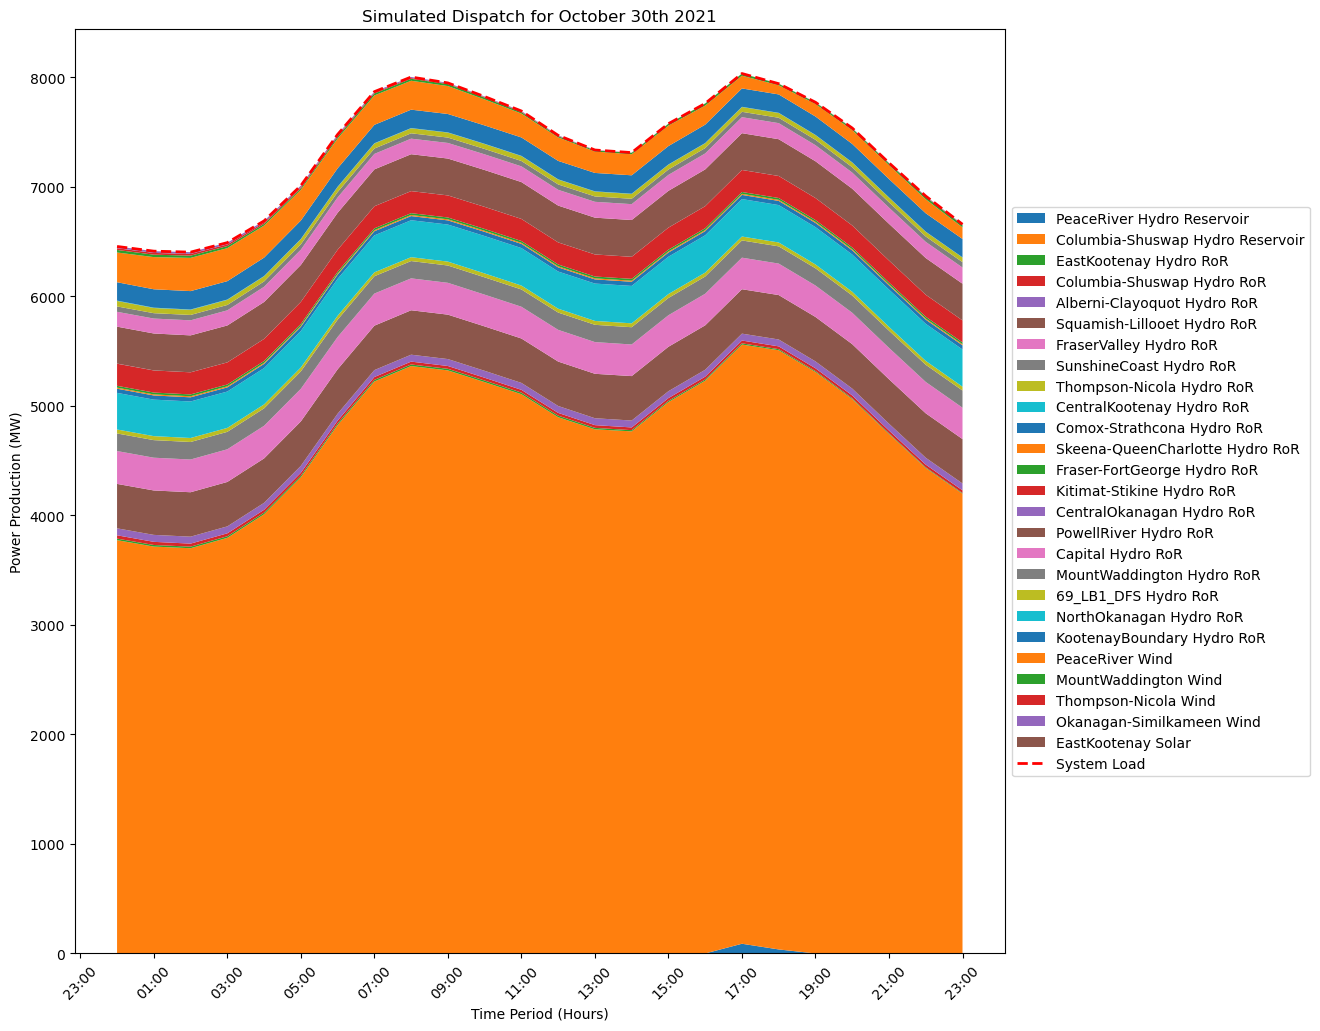

In [29]:
sys_load = network.loads_t.p_set.sum(axis=1)
legend_labels = []
prod_list = []
# Prepare plotting data
# (i) Reservoir
for key,values in res_region_p_dict.items():
    if values.sum() > 0:
        legend_labels.append(key + " Hydro Reservoir")
        prod_list.append(values)

# (ii) RoR
for key,values in ror_region_p_dict.items():
    if values.sum() > 0:
        legend_labels.append(key + " Hydro RoR")
        prod_list.append(values)

# (iii) Wind
for key,values in wind_region_p_dict.items():
    if values.sum() > 0:
        legend_labels.append(key + " Wind")
        prod_list.append(values)


# (iv) Solar
for key,values in pv_region_p_dict.items():
    if values.sum() > 0:
        legend_labels.append(key + " Solar")
        prod_list.append(values)


# Plotting
fig, ax = plt.subplots(figsize=(12,12))
fig,
ax.stackplot(prod_list[0].index, prod_list, labels=legend_labels)
ax.plot(sys_load,color='red',label='System Load',linestyle='--',linewidth=2)


date_format = mdates.DateFormatter('%H:00')  # Define the desired date format
ax.xaxis.set_major_formatter(date_format)
ax.xaxis.set_major_locator(mdates.HourLocator(interval=2)) 
plt.xticks(rotation=45)  # Rotate the tick labels by 45 degrees
plt.ylabel('Power Production (MW)')
plt.xlabel('Time Period (Hours)')
plt.title("Simulated Dispatch for October 30th 2021")

# plt.title("Simulated Dispatch for January 1st 2021")
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [30]:
def agg_sys_prod(p_dict):
    for idx,values in enumerate(p_dict.values()):
        if idx == 0:
            tot = values.copy()
        else:
            tot += values.copy()
    return tot


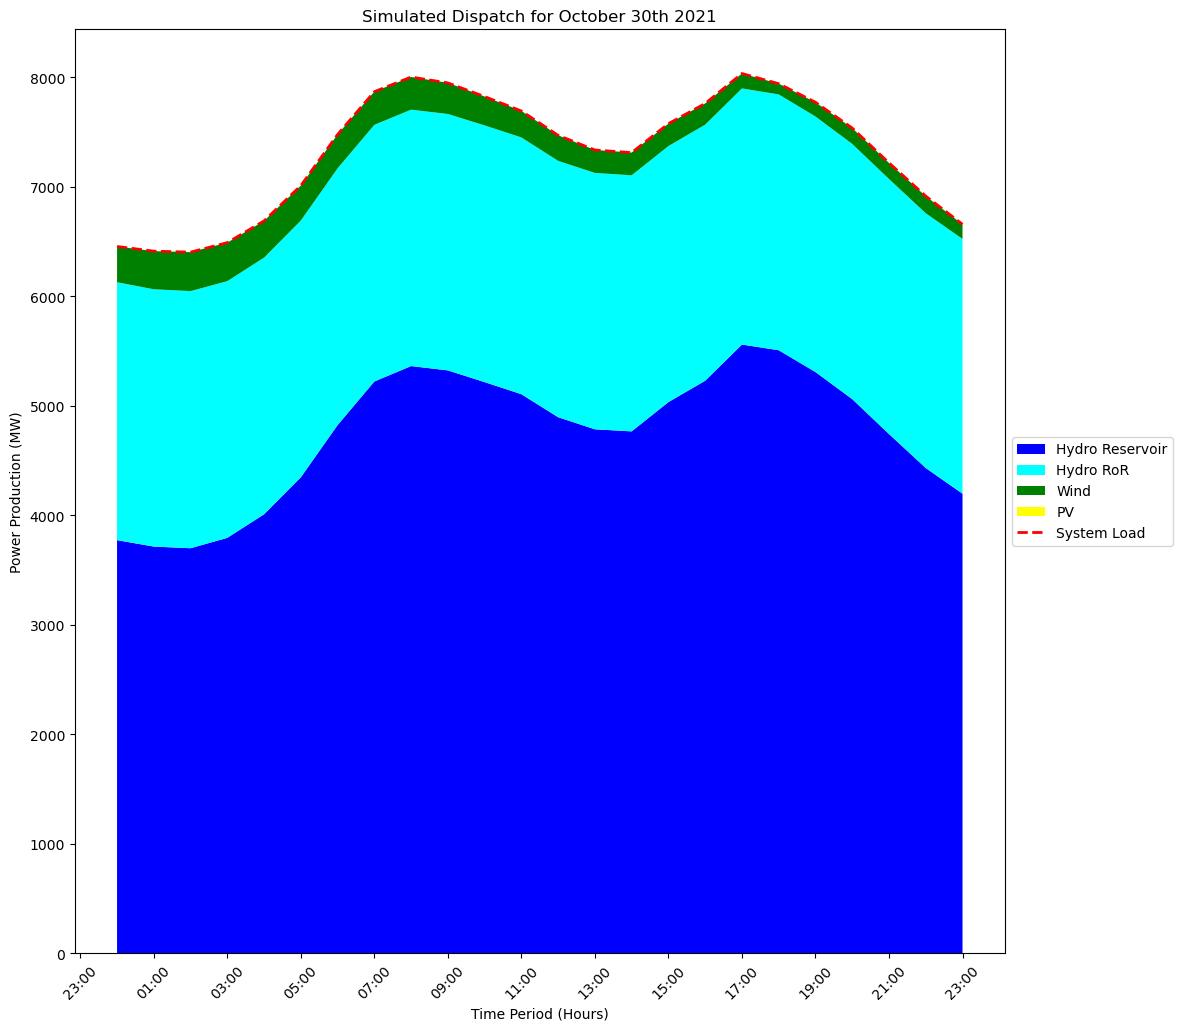

In [31]:
sys_load = network.loads_t.p_set.sum(axis=1)
legend_labels = []
prod_list = []

# Prepare plotting data
# (i) Reservoir
prod_list.append(agg_sys_prod(res_region_p_dict))
legend_labels.append('Hydro Reservoir')

# (ii) RoR
prod_list.append(agg_sys_prod(ror_region_p_dict))
legend_labels.append("Hydro RoR")


# (iii) Wind
prod_list.append(agg_sys_prod(wind_region_p_dict))
legend_labels.append("Wind")

# (iv) Solar
prod_list.append(agg_sys_prod(pv_region_p_dict))
legend_labels.append("PV")

# Plotting
fig, ax = plt.subplots(figsize=(12,12))
ax.stackplot(prod_list[0].index, prod_list, labels=legend_labels, colors=['blue', 'cyan','green','yellow'])
ax.plot(sys_load,color='red',label='System Load',linestyle='--',linewidth=2)


date_format = mdates.DateFormatter('%H:00')  # Define the desired date format
ax.xaxis.set_major_formatter(date_format)
ax.xaxis.set_major_locator(mdates.HourLocator(interval=2)) 
plt.xticks(rotation=45)  # Rotate the tick labels by 45 degrees
plt.ylabel('Power Production (MW)')
plt.xlabel('Time Period (Hours)')
plt.title("Simulated Dispatch for October 30th 2021")
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))